In [64]:
import numpy as np
import pandas as pd
from scipy.stats import norm, binom
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

import os
zad1_dir = "zad1"
os.makedirs(zad1_dir, exist_ok=True)
zad2_dir = "zad2"
os.makedirs(zad2_dir, exist_ok=True)
zad3_dir = "zad3"
os.makedirs(zad3_dir, exist_ok=True)
zad4_dir = "zad4"
os.makedirs(zad4_dir, exist_ok=True)

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

### Zad 1

In [66]:
from scipy import stats

n_values = [20, 50, 100]
n_simulations = 10000
alpha = 0.05
confidence_level = 1 - alpha

# returns theoretical mean and variance
def get_theoretical_params(dist_name, params):
    if dist_name == 'Normal':
        theta, sigma = params
        return theta, sigma**2
    elif dist_name == 'Logistic':
        theta, sigma = params
        return theta, (sigma**2 * np.pi**2) / 3
    elif dist_name == 'Student-t':
        r = params[0]
        return 0, r / (r - 2)
    elif dist_name == 'Laplace':
        theta, sigma = params
        return theta, 2 * sigma**2

In [67]:
distributions = {
    'Normal (a)': ('Normal', (0, 1)),
    'Normal (b)': ('Normal', (0, 2)),
    'Logistic (a)': ('Logistic', (0, 1)),
    'Logistic (b)': ('Logistic', (0, 2)),
    'Student-t (a)': ('Student-t', (3,)),
    'Student-t (b)': ('Student-t', (10,)),
    'Student-t (c)': ('Student-t', (20,)),
    'Laplace (a)': ('Laplace', (0, 1)),
    'Laplace (b)': ('Laplace', (0, 1/3)),
}

results = []

for n in n_values:
    z_score = stats.norm.ppf(1 - alpha/2)
    t_score = stats.t.ppf(1 - alpha/2, df=n-1)
    chi2_lower = stats.chi2.ppf(alpha/2, df=n-1)
    chi2_upper = stats.chi2.ppf(1 - alpha/2, df=n-1)

    for name, (dist_type, params) in distributions.items():
        if dist_type == 'Normal':
            data = stats.norm.rvs(loc=params[0], scale=params[1], size=(n_simulations, n))
        elif dist_type == 'Logistic':
            data = stats.logistic.rvs(loc=params[0], scale=params[1], size=(n_simulations, n))
        elif dist_type == 'Student-t':
            data = stats.t.rvs(df=params[0], size=(n_simulations, n))
        elif dist_type == 'Laplace':
            data = stats.laplace.rvs(loc=params[0], scale=params[1], size=(n_simulations, n))
        
        # true params
        true_mu, true_var = get_theoretical_params(dist_type, params)
        true_sigma = np.sqrt(true_var)

        # sample stats
        sample_mean = np.mean(data, axis=1)
        sample_var = np.var(data, ddof=1, axis=1)
        sample_std = np.sqrt(sample_var)

        # a) mean CI, known variance => z
        margin_known = z_score * (true_sigma / np.sqrt(n))
        ci_mu_known_lower = sample_mean - margin_known
        ci_mu_known_upper = sample_mean + margin_known
        cov_mu_known = np.mean((ci_mu_known_lower <= true_mu) & (true_mu <= ci_mu_known_upper))

        # b) mean CI, unknown variance => t
        margin_unknown = t_score * (sample_std / np.sqrt(n))
        ci_mu_unknown_lower = sample_mean - margin_unknown
        ci_mu_unknown_upper = sample_mean + margin_unknown
        cov_mu_unknown = np.mean((ci_mu_unknown_lower <= true_mu) & (true_mu <= ci_mu_unknown_upper))

        # c) variance CI => chi2
        ci_var_lower = ((n - 1) * sample_var) / chi2_upper
        ci_var_upper = ((n - 1) * sample_var) / chi2_lower
        cov_var = np.mean((ci_var_lower <= true_var) & (true_var <= ci_var_upper))

        results.append({
            'N': n,
            'Rozkład': name,
            'Pokrycie Mu (Znana Var)': cov_mu_known,
            'Pokrycie Mu (Nieznana Var)': cov_mu_unknown,
            'Pokrycie Var': cov_var
        })

df_results = pd.DataFrame(results)

table_mu_known = df_results.pivot(
    index='Rozkład', columns='N', values='Pokrycie Mu (Znana Var)'
)

table_mu_unknown = df_results.pivot(
    index='Rozkład', columns='N', values='Pokrycie Mu (Nieznana Var)'
)

table_var = df_results.pivot(
    index='Rozkład', columns='N', values='Pokrycie Var'
)

md_filename_pivot = os.path.join(zad1_dir, "table.md")
with open(md_filename_pivot, "w", encoding="utf-8") as f:
    
    f.write("**1. Pokrycie dla wartości oczekiwanej (Znana Wariancja)**\n\n")
    f.write(table_mu_known.to_markdown(floatfmt=".4f"))
    f.write("\n\n")  # Podwójny odstęp dla czytelności
    
    f.write("**2. Pokrycie dla wartości oczekiwanej (Nieznana Wariancja)**\n\n")
    f.write(table_mu_unknown.to_markdown(floatfmt=".4f"))
    f.write("\n\n")
    
    f.write("**3. Pokrycie dla wariancji**\n\n")
    f.write(table_var.to_markdown(floatfmt=".4f"))
    f.write("\n")

### Zad 2

In [43]:
# zad 2
# 1. próba z rozkładu
# 2. liczymy MLE (wzór trzeba na kartce policzyć)
# 3. Informacja Fishera (od MLE) - też trzeba wzór na kartce
# 4. Liczymy przedział ufności Theta_mle +- z_alpha/2 * sqrt(1/I(theta_mle)) i sprawdzamy czy prawdziwa theta jest w przedziale
# ten przedział w 4. to asymptotyczny przedział ufności
# powtarzamy to k razy (10_000) i liczymy mean tego wektora z 0 i 1 (1 jeśli prawdziwa theta jest w przedziale, 0 jeśli nie)
# no i to jest prawdopodobieństwo, że prawdziwa theta jest w przedziale ufności

# powtarzamy dla różnych n (2-100 co 1) i robimy wykres oś x - n, oś y - prawdopodobieństwo.
# Prosta linia na wysokości 0.95 powinna być widoczna
# Im większe n tym lepsze przybliżenie

# można zrobić oba przypadki parametru theta dla rozkładu beta na jednym wykresie (theta = 0.5 i theta = 5)

In [44]:
n_values = np.linspace(1, 200, 40, dtype=int)
theta_values = [0.5, 5]
n_simulations = 10000

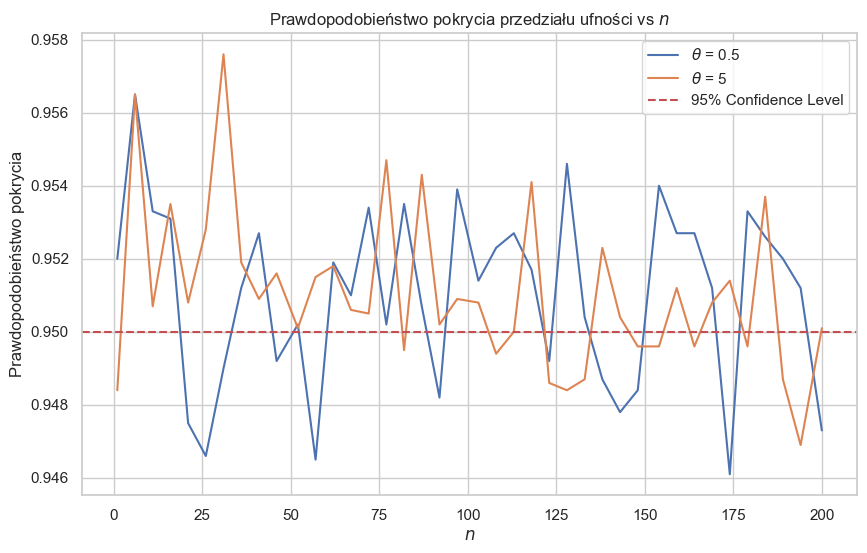

In [45]:
plt.figure(figsize=(10, 6))

for i, theta in enumerate(theta_values):
    coverage_probabilities = []
    for n in n_values:
        # 10000 wierszy, w każdym n próbek
        data = np.random.beta(theta, 1, size=(n_simulations, n))
        
        sum_log_x = np.sum(np.log(data), axis=1)
        theta_hats = -n / sum_log_x # wektor MLE długości n_simulations
        
        fisher_info = 1 / (theta_hats ** 2)  # wektor informacji Fishera długości n_simulations

        confidence_intervals_lower = theta_hats - norm.ppf(0.975) * np.sqrt(1 / (n*fisher_info))
        confidence_intervals_upper = theta_hats + norm.ppf(0.975) * np.sqrt(1 / (n*fisher_info))

        contains_theta = (confidence_intervals_lower <= theta) & (confidence_intervals_upper >= theta)

        coverage_probability = np.mean(contains_theta)
        coverage_probabilities.append(coverage_probability)

    plt.plot(n_values, coverage_probabilities, label=fr'$\theta$ = {theta}')
    
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Confidence Level')
plt.xlabel('$n$')
plt.ylabel('Prawdopodobieństwo pokrycia')
plt.title('Prawdopodobieństwo pokrycia przedziału ufności vs $n$')
plt.legend()
# plt.show()
plot_filename = os.path.join(zad2_dir, f"plots_beta.png")
plt.savefig(plot_filename, bbox_inches='tight')


In [46]:
n_values = np.linspace(1, 200, 40, dtype=int)
parameters = [(0, 1), (0, 2)]
n_simulations = 10000

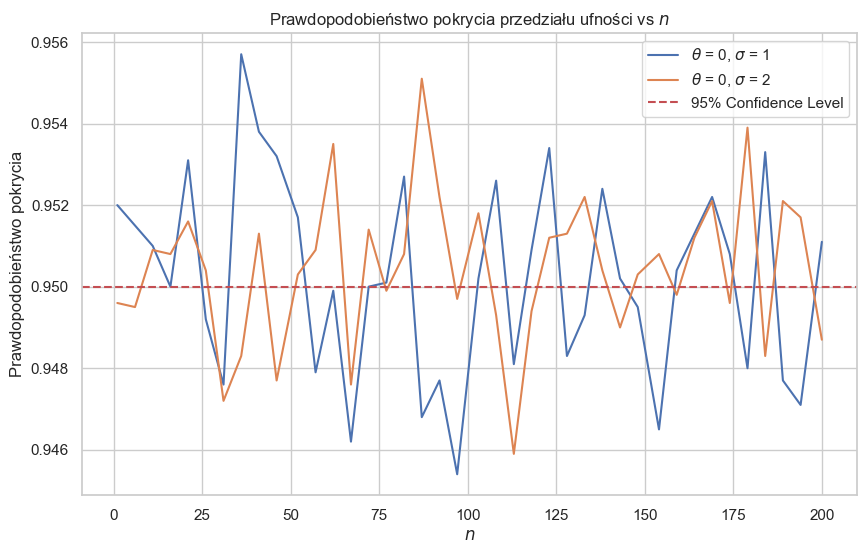

In [47]:
plt.figure(figsize=(10, 6))

for i, params in enumerate(parameters):
    theta, sigma = params
    coverage_probabilities = []
    for n in n_values:
        # 10000 wierszy, w każdym n próbek lognorm
        data = np.random.lognormal(mean=theta, sigma=sigma, size=(n_simulations, n))
        
        # wektor MLE długości n_simulations
        theta_hats = np.mean(np.log(data), axis=1)
        
        # wektor informacji Fishera długości n_simulations
        fisher_info = 1 / (sigma ** 2)

        confidence_intervals_lower = theta_hats - norm.ppf(0.975) * np.sqrt(1 / (n*fisher_info))
        confidence_intervals_upper = theta_hats + norm.ppf(0.975) * np.sqrt(1 / (n*fisher_info))

        contains_theta = (confidence_intervals_lower <= theta) & (confidence_intervals_upper >= theta)

        coverage_probability = np.mean(contains_theta)
        coverage_probabilities.append(coverage_probability)

    plt.plot(n_values, coverage_probabilities, label=fr'$\theta$ = {theta}, $\sigma$ = {sigma}')
    
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Confidence Level')
plt.xlabel(r'$n$')
plt.ylabel('Prawdopodobieństwo pokrycia')
plt.title(r'Prawdopodobieństwo pokrycia przedziału ufności vs $n$')
plt.legend()
# plt.show()
plot_filename = os.path.join(zad2_dir, f"plots_lognorm.png")
plt.savefig(plot_filename, bbox_inches='tight')


### Zad 3

In [48]:
# zad 3
# 1. próba z rozkładu
# 2. na tej samej próbie przedział ufności klasyczny i przedział ufności agrestiego-coull'a
# 3. sprawdzamy czy prawdziwa theta jest w przedziale
# 4. powtarzamy to k razy (10_000) i liczymy mean tego wektora z 0 i 1 (1 jeśli prawdziwa theta jest w przedziale, 0 jeśli nie)
# no i to jest prawdopodobieństwo, że prawdziwa theta jest w przedziale ufności
# dla różnych theta blisko 0 i 1

# wykres oś x - prawdziwe theta, oś y - prawdopodobieństwo pokrycia
# dwie linie - klasyczny i agrestiego-coull'a
# linia na wysokości 0.95 powinna być widoczna

In [49]:
n_values = [20, 50, 100]
theta_values = np.linspace(0.01, 0.99, 50)
n_simulations = 10000

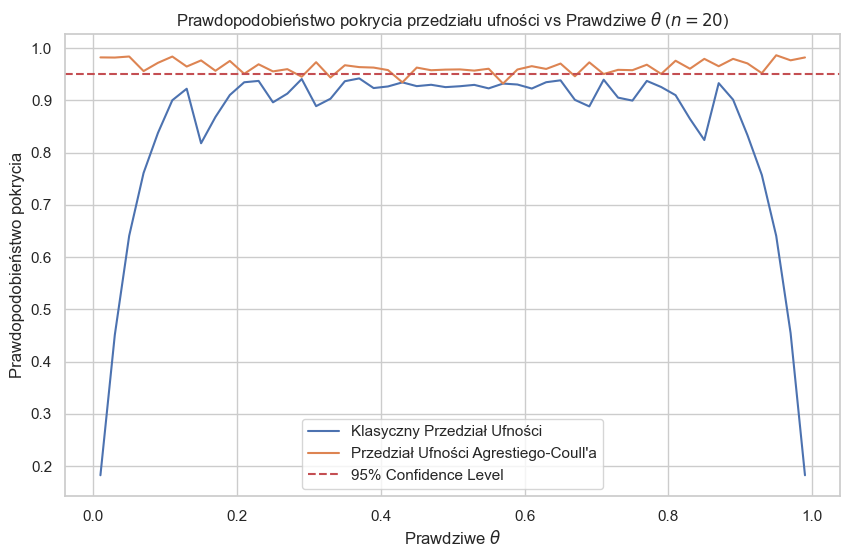

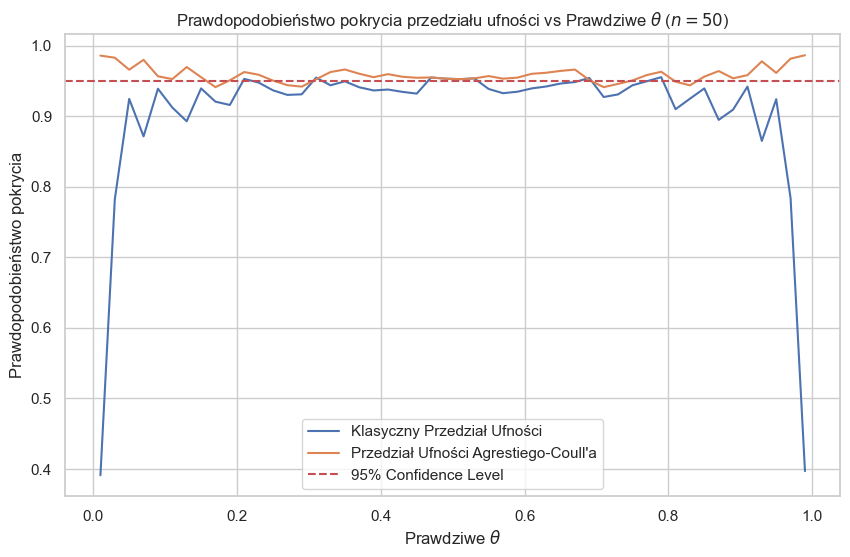

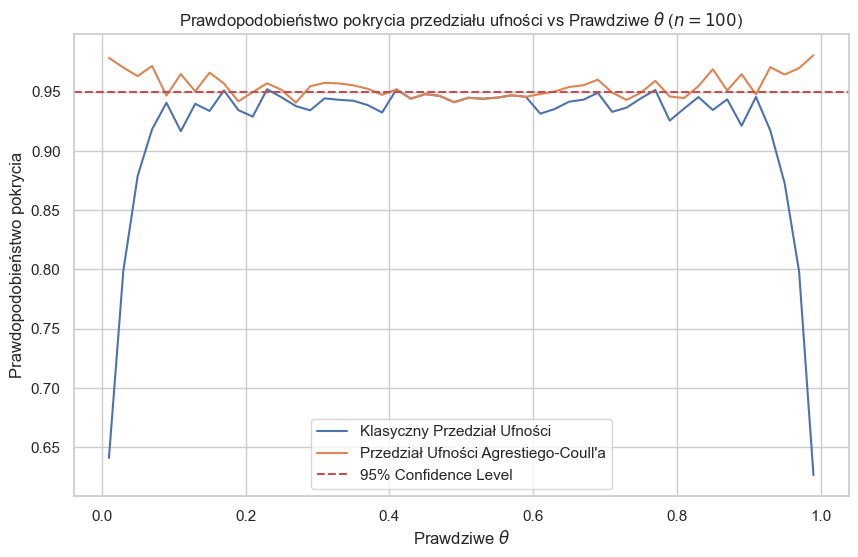

In [50]:
for n in n_values:
    classical_coverage = []
    agresti_coull_coverage = []
    
    for theta in theta_values:
        data = np.random.binomial(1, theta, size=(n_simulations, n))
        successes = np.sum(data, axis=1)
        
        # Klasyczny przedział ufności
        p_hats = successes / n
        se_classical = np.sqrt(p_hats * (1 - p_hats) / n)
        ci_lower_classical = p_hats - norm.ppf(0.975) * se_classical
        ci_upper_classical = p_hats + norm.ppf(0.975) * se_classical
        
        contains_theta_classical = (ci_lower_classical <= theta) & (ci_upper_classical >= theta)
        coverage_probability_classical = np.mean(contains_theta_classical)
        classical_coverage.append(coverage_probability_classical)
        
        # Przedział ufności Agrestiego-Coull'a
        n_tilde = n + 4
        p_tilde = (successes + 2) / n_tilde
        se_ac = np.sqrt(p_tilde * (1 - p_tilde) / n_tilde)
        ci_lower_ac = p_tilde - norm.ppf(0.975) * se_ac
        ci_upper_ac = p_tilde + norm.ppf(0.975) * se_ac
        
        contains_theta_ac = (ci_lower_ac <= theta) & (ci_upper_ac >= theta)
        coverage_probability_ac = np.mean(contains_theta_ac)
        agresti_coull_coverage.append(coverage_probability_ac)
    
    plt.figure(figsize=(10, 6))
    plt.plot(theta_values, classical_coverage, label='Klasyczny Przedział Ufności')
    plt.plot(theta_values, agresti_coull_coverage, label="Przedział Ufności Agrestiego-Coull'a")
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Confidence Level')
    plt.xlabel(r'Prawdziwe $\theta$')
    plt.ylabel('Prawdopodobieństwo pokrycia')
    plt.title(fr'Prawdopodobieństwo pokrycia przedziału ufności vs Prawdziwe $\theta$ ($n={n}$)')
    plt.legend()
    # plt.show()
    plot_filename = os.path.join(zad3_dir, f"plots_binom_n_{n}.png")
    plt.savefig(plot_filename, bbox_inches='tight')

### Zad 4

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

In [52]:
n_simulations = 10000
alpha = 0.05

In [53]:
def run_simulation_h0():
    mu_true = 0
    sigma = 2
    n = 50

    # a) single sample
    sample = np.random.normal(loc=mu_true, scale=sigma, size=n)
    
    # Test t-Studenta (H0: mu=0).
    p_val = stats.ttest_1samp(sample, popmean=0)[1]
    
    print(f"Podpunkt a) Pojedynczy eksperyment:")
    print(f"  P-wartość: {p_val:.4f}")
    print(f"  Decyzja: {'Odrzucamy H0' if p_val < alpha else 'Brak podstaw do odrzucenia H0'}")

    # b) multiple simulations
    samples_matrix = np.random.normal(loc=mu_true, scale=sigma, size=(n_simulations, n))

    p_values_h0 = stats.ttest_1samp(samples_matrix, popmean=0, axis=1)[1]

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    print(f"\nPodpunkt b) Analiza 10000 symulacji:")

    # Histogram
    ax[0].hist(p_values_h0, bins=30, density=True, color='skyblue', edgecolor='black', alpha=0.7)
    ax[0].axhline(1, color='red', linestyle='--', label='Oczekiwany rozkład jedn. (Uniform)')
    ax[0].set_title('Histogram p-wartości przy H0 prawdziwej')
    ax[0].set_xlabel('p-wartość')
    ax[0].legend()
    
    # QQ-plot
    sm.qqplot(p_values_h0, dist=stats.uniform, line='45', ax=ax[1])
    ax[1].set_title('QQ-plot p-wartości vs Uniform(0,1)')
    
    plt.tight_layout()
    # plt.show()
    plot_filename = os.path.join(zad4_dir, f"plot_h0.png")
    plt.savefig(plot_filename, bbox_inches='tight')
    
    # przedział ufności błędu I rodzaju
    rejections = np.sum(p_values_h0 < alpha)
    type_I_error_rate = rejections / n_simulations
    
    se = np.sqrt(type_I_error_rate * (1 - type_I_error_rate) / n_simulations)
    ci_lower = type_I_error_rate - 1.96 * se
    ci_upper = type_I_error_rate + 1.96 * se
    
    print(f"  Empiryczny błąd I rodzaju: {type_I_error_rate:.4f}")
    print(f"  95% Przedział ufności: [{ci_lower:.4f}, {ci_upper:.4f}]")
    print(f"  (Oczekujemy wartości bliskiej {alpha})")

Podpunkt a) Pojedynczy eksperyment:
  P-wartość: 0.7288
  Decyzja: Brak podstaw do odrzucenia H0

Podpunkt b) Analiza 10000 symulacji:
  Empiryczny błąd I rodzaju: 0.0491
  95% Przedział ufności: [0.0449, 0.0533]
  (Oczekujemy wartości bliskiej 0.05)


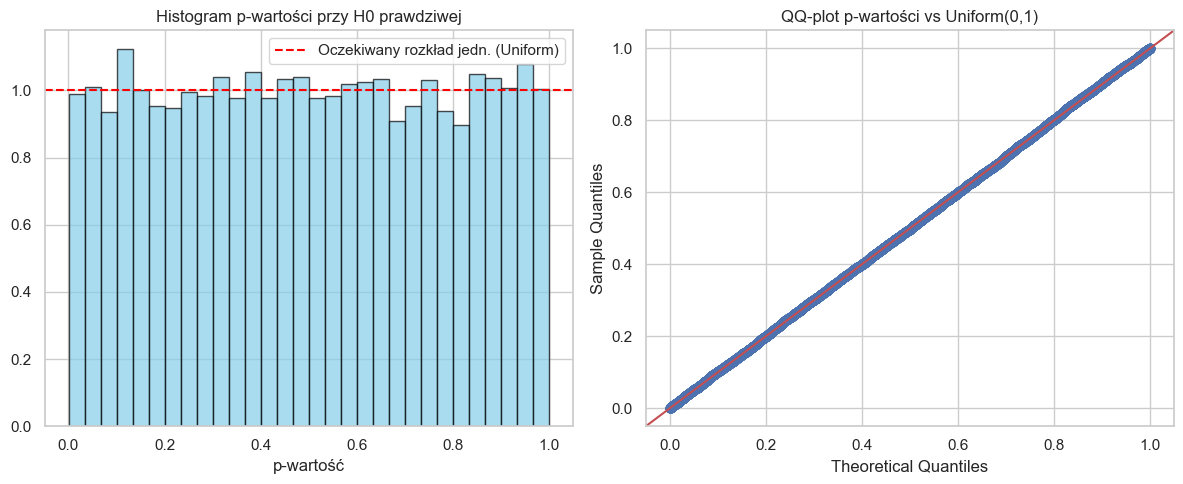

In [54]:
run_simulation_h0()

In [55]:
def run_simulation_h1():
    mu_true = 0.3
    sigma_sq = 4
    sigma = np.sqrt(sigma_sq)
    n = 50
    
    # c) single sample
    sample = np.random.normal(loc=mu_true, scale=sigma, size=n)
    p_val = stats.ttest_1samp(sample, popmean=0)[1]
    
    print(f"Podpunkt c) Pojedynczy eksperyment:")
    print(f"  P-wartość: {p_val:.4f}")
    print(f"  Decyzja: {'Odrzucamy H0 (Przyjmujemy H1)' if p_val < alpha else 'Brak podstaw do odrzucenia H0'}")

    # d) multiple simulations
    samples_matrix = np.random.normal(loc=mu_true, scale=sigma, size=(n_simulations, n))
    p_values_h1 = stats.ttest_1samp(samples_matrix, popmean=0, axis=1)[1]
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    print(f"\nPodpunkt d) Analiza 10000 symulacji:")

    # Histogram    
    ax[0].hist(p_values_h1, bins=30, density=True, color='lightgreen', edgecolor='black', alpha=0.7)
    ax[0].set_title('Histogram p-wartości przy H1 prawdziwej')
    ax[0].set_xlabel('p-wartość')
    
    # QQ-plot
    sm.qqplot(p_values_h1, dist=stats.uniform, line='45', ax=ax[1])
    ax[1].set_title('QQ-plot p-wartości vs Uniform(0,1)')
    
    plt.tight_layout()
    # plt.show()
    plot_filename = os.path.join(zad4_dir, f"plot_h1.png")
    plt.savefig(plot_filename, bbox_inches='tight')

    # Przedział ufności dla mocy testu
    rejections = np.sum(p_values_h1 < alpha)
    power = rejections / n_simulations
    
    # Przedział ufności dla mocy
    se = np.sqrt(power * (1 - power) / n_simulations)
    ci_lower = power - 1.96 * se
    ci_upper = power + 1.96 * se
    
    print(f"  Empiryczna moc testu: {power:.4f}")
    print(f"  95% Przedział ufności dla mocy: [{ci_lower:.4f}, {ci_upper:.4f}]")

Podpunkt c) Pojedynczy eksperyment:
  P-wartość: 0.0283
  Decyzja: Odrzucamy H0 (Przyjmujemy H1)

Podpunkt d) Analiza 10000 symulacji:
  Empiryczna moc testu: 0.1812
  95% Przedział ufności dla mocy: [0.1737, 0.1887]


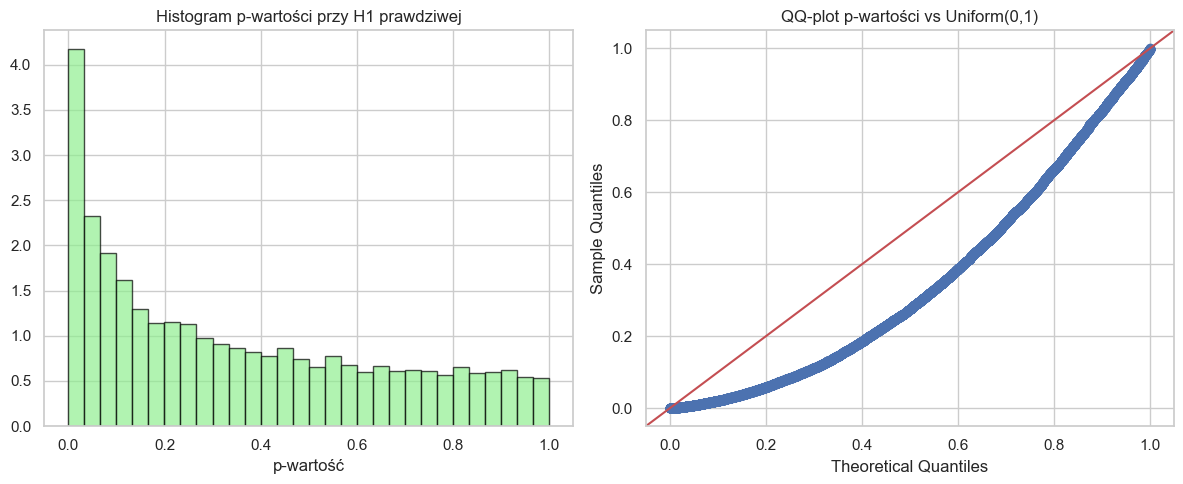

In [56]:
run_simulation_h1()

In [57]:
# e) Power Analysis
def plot_power_analysis():    
    n_base = 50
    mu1_base = 0.3
    sigma_sq_base = 4
    
    def calculate_power(n, mu_true, sigma_sq, n_sim=2000):
        sigma = np.sqrt(sigma_sq)
        data = np.random.normal(loc=mu_true, scale=sigma, size=(n_sim, n))

        p_vals = stats.ttest_1samp(data, popmean=0, axis=1)[1]
        return np.mean(p_vals < 0.05)

    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    # 1. Moc vs mu1 (przy ustalonym n, sigma^2)
    mu_values = np.linspace(0, 1.0, 20) 
    powers_mu = [calculate_power(n_base, m, sigma_sq_base) for m in mu_values]
    
    ax[0].plot(mu_values, powers_mu, 'o-', color='blue')
    ax[0].set_title(r'Moc testu vs $\mu_1$')
    ax[0].set_xlabel(r'$\mu_1$')
    ax[0].set_ylabel('Moc testu')
    ax[0].grid(True)

    # 2. Moc vs n (przy ustalonym mu1, sigma^2)
    n_values = np.arange(10, 200, 10)
    powers_n = [calculate_power(n, mu1_base, sigma_sq_base) for n in n_values]
    
    ax[1].plot(n_values, powers_n, 'o-', color='green')
    ax[1].set_title(r'Moc testu vs $n$')
    ax[1].set_xlabel(r'Liczebność próby $n$')
    ax[1].grid(True)

    # 3. Moc vs sigma^2 (przy ustalonym mu1, n)
    sigma_sq_values = np.linspace(1, 10, 20)
    powers_sig = [calculate_power(n_base, mu1_base, s_sq) for s_sq in sigma_sq_values]
    
    ax[2].plot(sigma_sq_values, powers_sig, 'o-', color='red')
    ax[2].set_title(r'Moc testu vs $\sigma^2$')
    ax[2].set_xlabel(r'Wariancja $\sigma^2$')
    ax[2].grid(True)
    
    plt.tight_layout()
    # plt.show()
    plot_filename = os.path.join(zad4_dir, f"plot_power.png")
    plt.savefig(plot_filename, bbox_inches='tight')

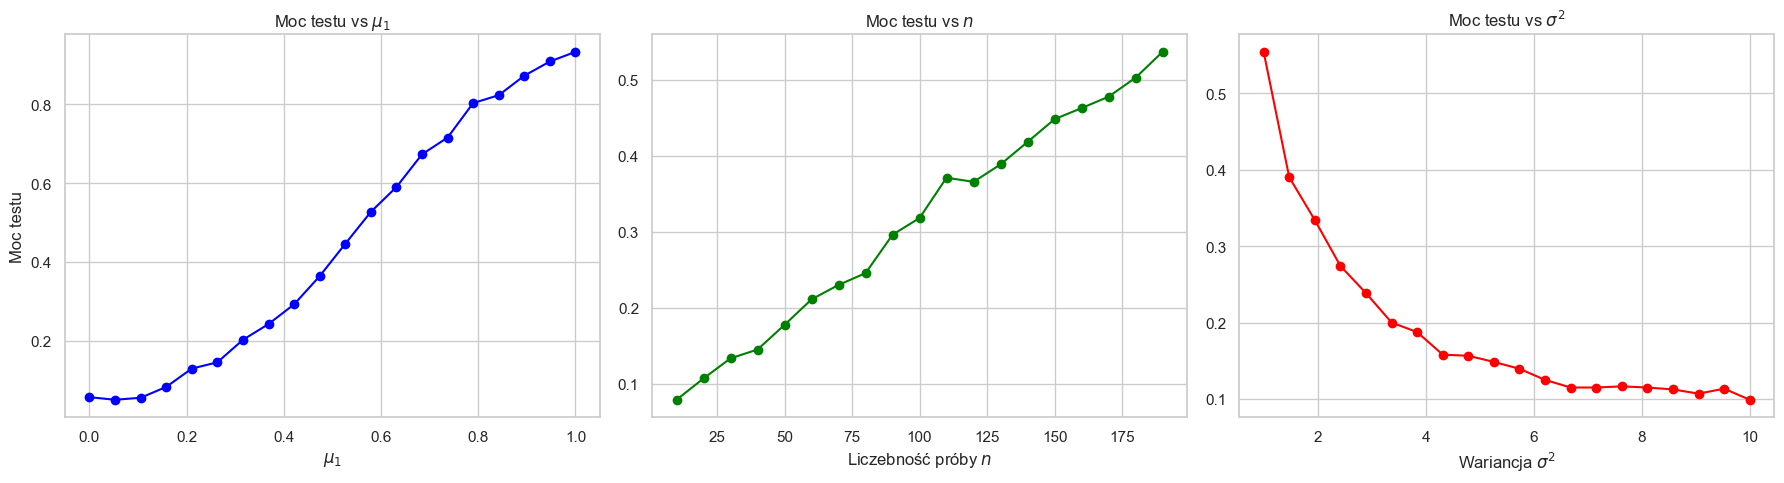

In [58]:
plot_power_analysis()